In [122]:
import numpy as np
import pandas as pd
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import seaborn as sns
from matplotlib import pyplot as plt
import re
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

In [2]:
cleaned_data = pd.read_csv("/content/cleaned_df.csv")

In [9]:
cleaned_data = cleaned_data.drop(columns = "Unnamed: 0")

In [15]:
numeric_data = cleaned_data.drop(columns = ["Company Ticker", 
                                                 "Sector", 
                                                 "Class",
                                                 "PRICE VAR [%]"
                                                 ])

In [33]:
Y_1 = cleaned_data['Class']
Y_2 = cleaned_data["PRICE VAR [%]"]

In [37]:
cat_1 = cleaned_data['Company Ticker']
cat_2 = cleaned_data['Sector']

In [40]:
pd.get_dummies(cat_1, prefix='Company')

,Company_A,Company_AA,Company_AABA,Company_AAL,Company_AAMC,Company_AAME,Company_AAN,Company_AAOI,Company_AAON,Company_AAPL,Company_AAT,Company_AAU,Company_AAWW,Company_AAXN,Company_AB,Company_ABB,Company_ABBV,Company_ABC,Company_ABCB,Company_ABEO,Company_ABEV,Company_ABG,Company_ABIL,Company_ABIO,Company_ABM,Company_ABMD,Company_ABR,Company_ABT,Company_ABTX,Company_ABUS,Company_AC,Company_ACAD,Company_ACBI,Company_ACC,Company_ACCO,Company_ACER,Company_ACGL,Company_ACH,Company_ACHC,Company_ACHN,...,Company_XRX,Company_XSPA,Company_XTLB,Company_XTNT,Company_XXII,Company_XYL,Company_Y,Company_YELP,Company_YGYI,Company_YIN,Company_YNDX,Company_YORW,Company_YPF,Company_YRCW,Company_YRD,Company_YRIV,Company_YTEN,Company_YUM,Company_YUMA,Company_YY,Company_Z,Company_ZAGG,Company_ZAYO,Company_ZBH,Company_ZBRA,Company_ZEN,Company_ZEUS,Company_ZFGN,Company_ZG,Company_ZGNX,Company_ZION,Company_ZIOP,Company_ZIXI,Company_ZN,Company_ZNGA,Company_ZNH,Company_ZSAN,Company_ZTS,Company_ZUMZ,Company_ZYNE
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18625,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18626,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18627,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18628,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## too sparse, drop company ticker

In [46]:
cat_data = pd.get_dummies(cat_2, prefix='sector')

## Numeric Data

In [59]:
check_corr = pd.concat([numeric_data,Y_1],axis = 1)

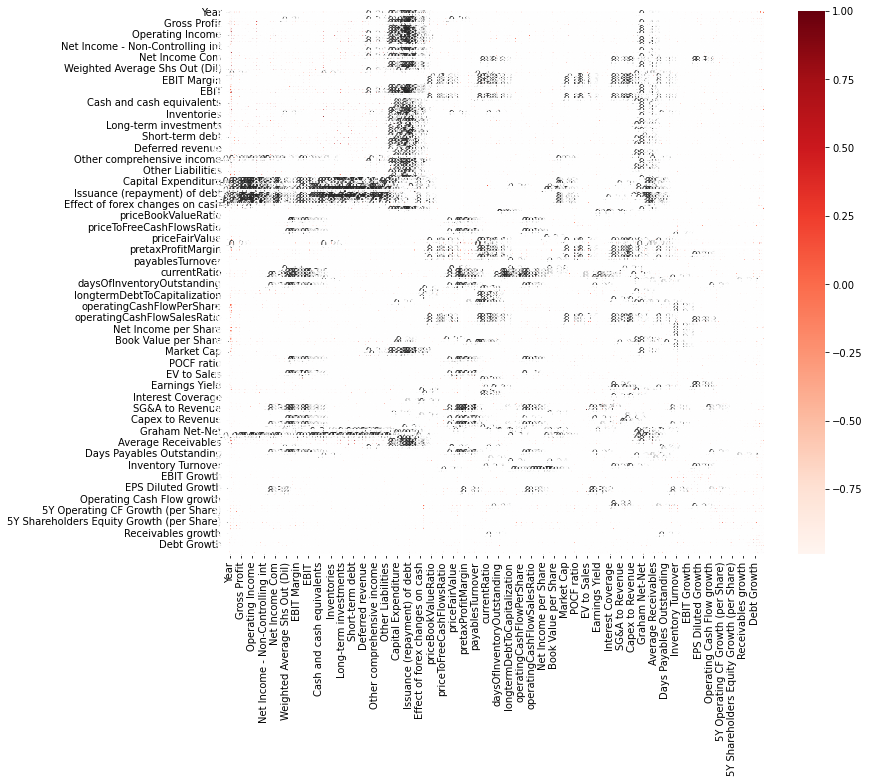

In [60]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = check_corr.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

## set correlation threshold to 0.08 and 23 features left

In [72]:
#Correlation with output variable
cor_target = abs(cor["Class"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.08]
relevant_features

EPS                                       0.153152
EPS Diluted                               0.153361
Dividend per Share                        0.098415
priceToOperatingCashFlowsRatio            0.096752
returnOnEquity                            0.115810
quickRatio                                0.088743
cashRatio                                 0.092666
companyEquityMultiplier                   0.087790
Market Cap                                0.084366
Enterprise Value                          0.087281
POCF ratio                                0.096318
Enterprise Value over EBITDA              0.111517
EV to Operating cash flow                 0.093160
Earnings Yield                            0.121761
Free Cash Flow Yield                      0.109021
Graham Number                             0.100592
Graham Net-Net                            0.082992
ROE                                       0.115979
Weighted Average Shares Growth            0.097081
Weighted Average Shares Diluted

In [76]:
rele_columns = relevant_features.index[:-1]

In [83]:
rele_columns

Index(['EPS', 'EPS Diluted', 'Dividend per Share',
       'priceToOperatingCashFlowsRatio', 'returnOnEquity', 'quickRatio',
       'cashRatio', 'companyEquityMultiplier', 'Market Cap',
       'Enterprise Value', 'POCF ratio', 'Enterprise Value over EBITDA',
       'EV to Operating cash flow', 'Earnings Yield', 'Free Cash Flow Yield',
       'Graham Number', 'Graham Net-Net', 'ROE',
       'Weighted Average Shares Growth',
       'Weighted Average Shares Diluted Growth',
       '5Y Revenue Growth (per Share)', '3Y Revenue Growth (per Share)'],
      dtype='object')

In [80]:
corr_2 = numeric_data[rele_columns]

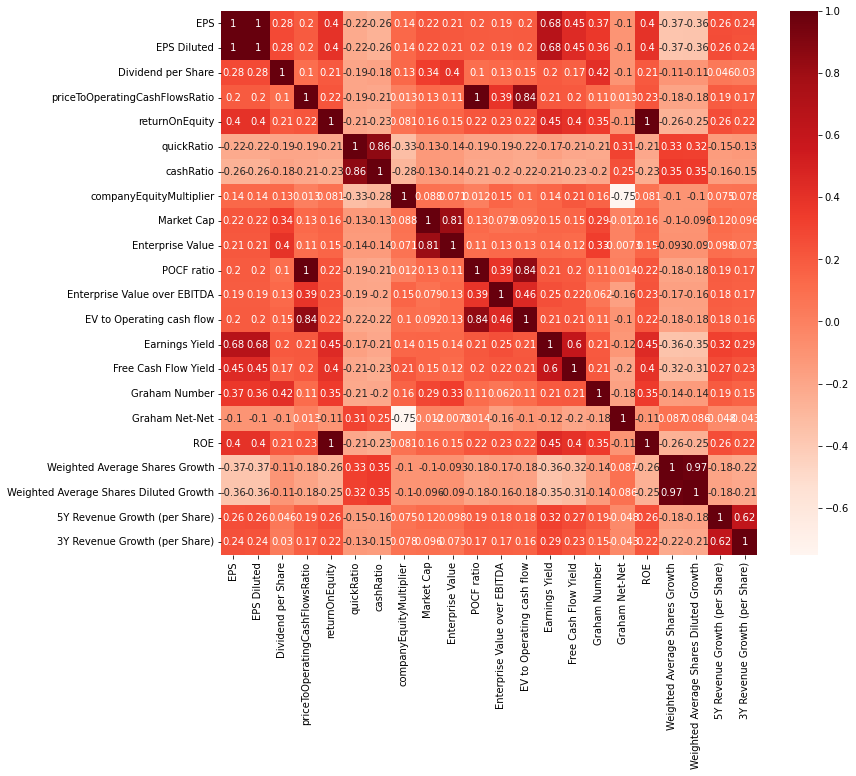

In [82]:
plt.figure(figsize=(12,10))
cor = corr_2.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

## we can see that EPS and EPS Diluted; cashRatio and quickRatio; POCF ratio and priceToOperatingCashFlowsRatio; EV to Operating cash flow and priceToOperatingCashFlowsRatio; ROE and returnOnEquity; Graham Net-Net and companyEquityMultiplier; Enterprise Value and Market Cap; EV to Operating cash flow and POCF ratio; Weighted Average Shares Diluted Growth and Weighted Average Shares Growth are highly correlated

Thus, we drop one of each pair: EPS Diluted, quickRatio, POCF ratio, priceToOperatingCashFlowsRatio,returnOnEquity,Enterprise Value, companyEquityMultiplier, Weighted Average Shares Diluted Growth.

In [84]:
rest_features = ['EPS', 'Dividend per Share', 
       'cashRatio', 'Market Cap',
      'Enterprise Value over EBITDA',
       'EV to Operating cash flow', 'Earnings Yield', 'Free Cash Flow Yield',
       'Graham Number', 'Graham Net-Net', 'ROE',
       'Weighted Average Shares Growth',
       '5Y Revenue Growth (per Share)', '3Y Revenue Growth (per Share)']

In [85]:
selected_features = numeric_data[rest_features]

In [87]:
final_features = pd.concat([selected_features,cat_2],axis = 1)

In [91]:
df = pd.concat([final_features,Y_1],axis = 1)

In [103]:
df = df.sample(frac = 1) # we shuffle the data so that our train/test split will be truly random

train_proportion = 0.8
n = len(df)
print('Size of dataset: ', str(n))

# Put the first ntrain observations in the DataFrame df into the training set, and the rest into the test set
t = int(train_proportion * n)

target = df['Class']
price_columns = ['Class']
data = df.loc[:, ~df.columns.isin(price_columns)]

# the following variable records the features of examples in the training set
train_x = data.iloc[:t]
# the following variable records the features of examples in the test set
test_x = data.iloc[t:]
# the following variable records the labels of examples in the training set
train_y = target[:t]
# the following variable records the labels of examples in the test set
test_y = target[t:]

Size of dataset:  18630


In [107]:
train_x_np = np.asarray(train_x)
test_x_np = np.asarray(test_x)
train_y_np = np.asarray(train_y)
test_y_np = np.asarray(test_y)

## normalization

In [111]:
def normalize(x,s=None,m=None):
  if s is None or m is None:
    s = np.std(x,axis=0)
    m = np.mean(x,axis=0)
  x = (x-m)/s
  return x,s,m

In [113]:
x,s,m = normalize(train_x_np[:,:-11])
x_test,_,_ = normalize(test_x_np[:,:-11],s,m)

In [114]:
train_x_np = np.concatenate((x,train_x_np[:,-11:]),axis = 1)
test_x_np = np.concatenate((x_test,test_x_np[:,-11:]),axis = 1)

In [118]:
clf = LogisticRegression(random_state=0).fit(train_x_np, train_y_np)

In [119]:
clf.score(test_x_np, test_y_np)

0.6172839506172839

In [120]:
y_pred = clf.predict(test_x_np)

In [123]:
f1_score(test_y_np, y_pred, average='weighted')

0.5977484924588589